In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

C:\Users\Arthur\AppData\Local\Temp\ipykernel_14768\1588790111.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
df = pd.read_csv('video Metrics.tsv', sep='\t')

In [3]:
df = df[['Participant', 'Interval', 'Event_type', 'Start', 'Duration', 'FixationPointX', 'FixationPointY', 'Average_pupil_size']]

x = df['FixationPointX'] * 1280
y = df['FixationPointY'] * 720

In [4]:
test = df.loc[(df['Start'] > 21) & (df['Start'] < 66)]
test.head(50)

,Participant,Interval,Event_type,Start,Duration,FixationPointX,FixationPointY,Average_pupil_size
3,Jelle,1,Fixation,24,8,0.56226,0.55613,3.30061
4,Jelle,1,Fixation,33,8,0.55881,0.55414,3.28229
5,Jelle,1,Fixation,41,8,0.55783,0.54562,3.28234
6,Jelle,1,Fixation,49,8,0.56179,0.54520,3.27251
7,Jelle,1,Fixation,58,8,0.53556,0.53010,3.29247
16453,Jelle2,1,Fixation,30,8,0.55306,0.54257,3.47567
16454,Jelle2,1,Fixation,38,8,0.55110,0.53583,3.49287
16455,Jelle2,1,Fixation,46,8,0.55358,0.54387,3.48483
16456,Jelle2,1,Fixation,55,8,0.55285,0.53542,3.46145
16457,Jelle2,1,Fixation,63,8,0.54258,0.53202,3.48021


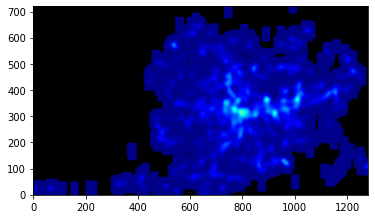

In [75]:
heatmap, xedges, yedges = np.histogram2d(df['FixationPointX'] * 1280, df['FixationPointY'] * 720, bins=(1280, 720))
heatmap *= 255
heatmap = heatmap.astype(np.uint8)
heatmap = 255 - heatmap
heatmap = gaussian_filter(heatmap, sigma=7).T
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

heatmap[np.where((heatmap==heatmap[700][0]).all(axis=2))] = [0, 0, 0]

plt.clf()
plt.imshow(heatmap, origin='lower')
plt.show()


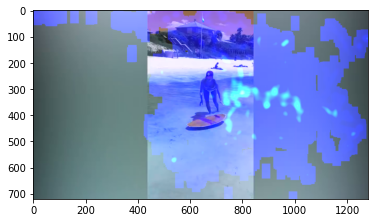

In [84]:
vidcap = cv2.VideoCapture('vid.mp4')
success, frame = vidcap.read()

plt.imshow(cv2.addWeighted(frame, 1, heatmap, 1, 0))